In [1]:
# Import libraries
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway



In [2]:
# Import dataframe
platform_catalog = pd.read_csv(r"C:\Users\kimbe\Documents\Capstone\Streaming_Analysis\data\cleaned\streaming_catalog.csv")

#Import popular title dataframe
popular_titles = pd.read_csv(r"C:\Users\kimbe\Documents\Capstone\Streaming_Analysis\data\working\top_rated_imdb_filtered.csv")


In [3]:
# Melt the platform_catalog dataframe to long format
long_platform_catalog = pd.melt(platform_catalog, id_vars=['imdbId', 'title', 'type', 
                                                      'releaseYear', 'rating', 'numVotes', 'highlyRated',
                                                      'exclusive', 'exclusiveHighlyRated', 'popularTitle'], 
                  value_vars=['Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple'],
                  var_name='Platform', value_name='Available')

# drop columns with available = 0
long_platform_catalog = long_platform_catalog[long_platform_catalog['Available'] == 1]

# Drop available column
long_platform_catalog.drop(columns=['Available'], inplace=True)


# Display the long format dataframe
long_platform_catalog.head()


,imdbId,title,type,releaseYear,rating,numVotes,highlyRated,exclusive,exclusiveHighlyRated,popularTitle,Platform
2,tt0004873,Alice in Wonderland,movie,1915,6.1,804,0,1,0,0,Amazon
3,tt0005078,The Cheat,movie,1915,6.5,2893,0,1,0,0,Amazon
4,tt0005302,"Fanchon, the Cricket",movie,1915,6.4,366,0,1,0,0,Amazon
5,tt0005339,A Fool There Was,movie,1915,5.7,1080,0,1,0,0,Amazon
7,tt0006327,Young Romance,movie,1915,5.8,223,0,1,0,0,Amazon


# Analyze the availability of high-rated content (IMDb ≥ 7.5) across platforms using an ANOVA test


**Plan:** 
We will test if there are significant differences in high-rated content percentage between platforms.

1. Null Hypothesis (H₀): There are no significant differences in high-rated content percentage across platforms.
2. Alternative Hypothesis (H₁): There is a significant difference in this variables across platforms.

**Variable Analyzed:**

* High-Rated Content (%)

---

**Results**
* F-statistic = 5.058636723614688, p-value = 0.0004540992208318616

* Percent per platform:
    * HBO: 32.16%
    * Hulu: 26.54%
    * Netflix: 19.59%
    * Apple: 16.92%
    * Amazon: 11.24%    


---

**Summary**
1. F-statistic:

* The F-statistic (5.059) indicates the ratio of variance between group means (platforms) to the variance within groups.

* A higher F-statistic suggests greater variability between groups compared to within groups.

2. p-value:

* The p-value (0.00045) is significantly lower than a common significance threshold (e.g., α = 0.05).

* **This means we can reject the null hypothesis (H₀)**
 

3. All Comparisons are Significant:

* All pairwise comparisons have a p-adj ≤ 0.05, meaning the differences between the mean high-rated content percentages are statistically significant at the 5% significance level.

* The confidence intervals for all pairs exclude 0, reinforcing the significance.

4. Largest Difference:

* The most significant difference is between Amazon and HBO with a mean difference of 20.93%.

5. Smallest Difference:

* The smallest significant difference is between Apple and Netflix with a mean difference of 2.67%.

In [4]:
# Define a threshold for high-rated content (e.g., rating >= 7.5)
high_rated_df = long_platform_catalog[long_platform_catalog['rating'] >= 7.5]

# Group data by platform and calculate high-rated content percentage for each platform
platform_high_rated = high_rated_df.groupby('Platform').size() / long_platform_catalog.groupby('Platform').size() * 100

# Run ANOVA to compare the high-rated content percentages across platforms
anova_result = stats.f_oneway(*[high_rated_df[high_rated_df['Platform'] == platform]['rating'] 
                               for platform in long_platform_catalog['Platform'].unique()])
print(f'ANOVA result for High-Rated Content: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}')


ANOVA result for High-Rated Content: F-statistic = 5.058636723614688, p-value = 0.0004540992208318616


In [5]:
#Calculate the percentage of high-rated content for each platform
high_rated_per_platform = long_platform_catalog.groupby('Platform')['highlyRated'].mean() * 100

# Display the results
print(high_rated_per_platform)


Platform
Amazon     11.235706
Apple      16.919379
HBO        32.162373
Hulu       26.537458
Netflix    19.587780
Name: highlyRated, dtype: float64


Conduct a Tukey HSD test 

In [6]:
# Perform Tukey's HSD Test
tukey_result = pairwise_tukeyhsd(endog=long_platform_catalog['highlyRated'],
                                 groups=long_platform_catalog['Platform'],
                                 alpha=0.05)

# Print Tukey's HSD Test Results
print(tukey_result.summary())


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
Amazon   Apple   0.0568   0.0  0.0453  0.0684   True
Amazon     HBO   0.2093   0.0  0.1887  0.2298   True
Amazon    Hulu    0.153   0.0  0.1329  0.1731   True
Amazon Netflix   0.0835   0.0  0.0699  0.0971   True
 Apple     HBO   0.1524   0.0  0.1308  0.1741   True
 Apple    Hulu   0.0962   0.0  0.0749  0.1174   True
 Apple Netflix   0.0267   0.0  0.0115  0.0419   True
   HBO    Hulu  -0.0562   0.0 -0.0835  -0.029   True
   HBO Netflix  -0.1257   0.0 -0.1486 -0.1029   True
  Hulu Netflix  -0.0695   0.0 -0.0919 -0.0471   True
----------------------------------------------------


Create a bar chart to visually represent the distribution of high-rated content across streaming platforms.

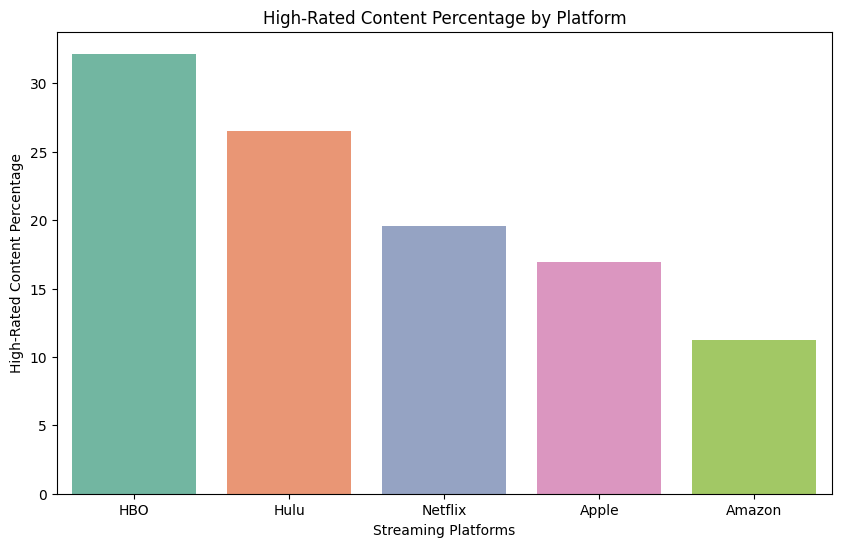

In [7]:
# Platforms and their high-rated content percentages
platforms = ['Amazon', 'Apple', 'HBO', 'Hulu', 'Netflix']
high_rated_content_percentages = [high_rated_per_platform[platform] for platform in platforms]

# Create a DataFrame to combine the platforms and percentages
df = pd.DataFrame({'Platform': platforms, 'High-Rated Content (%)': high_rated_content_percentages})

# Sort the DataFrame by the 'High-Rated Content (%)' column in descending order
df = df.sort_values(by='High-Rated Content (%)', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Platform', y='High-Rated Content (%)', data=df, palette='Set2', hue='Platform')

# Adding labels and title
plt.xlabel('Streaming Platforms')
plt.ylabel('High-Rated Content Percentage')
plt.title('High-Rated Content Percentage by Platform')

# Save the plot
plt.savefig("C:\\Users\\kimbe\\Documents\\Capstone\\Streaming_Analysis\\outputs\\high_rated_content_percentage_by_platform.png")

# Display the plot
plt.show()


# Assess the availability of exclusive high-rated content across streaming platforms using an ANOVA test

**Plan:**
We will test if there are significant differences in the percentage of exclusive high-rated content across streaming platforms.

1. Null Hypothesis (H₀): There are no significant differences in the percentage of exclusive high-rated content across platforms.
2. Alternative Hypothesis (H₁): There is a significant difference in this variable across platforms.

**Variable Analyzed:**

* Exclusive High-Rated Content (%)

---

**Results:**
* ANOVA result for Exclusive High-Rated Content:

    * F-statistic = 242.778
    * p-value = 1.06e-206
* Percent per platform:
    * HBO: 29.31%
    * Hulu: 19.16%
    * Netflix: 17.64%
    * Apple: 14.19%
    * Amazon: 9.96%

---

**Summary**
1. F-statistic:

    * The F-statistic (242.778) indicates the ratio of variance between group means (platforms) to the variance within groups.
    * A higher F-statistic suggests greater variability between groups compared to within groups.
2. p-value:

    * The p-value (1.06e-206) is significantly lower than a common significance threshold (e.g., α = 0.05).
    * **This means we can reject the null hypothesis (H₀).**

3. All Comparisons Are Significant (Except Hulu vs. Netflix):

    * All pairwise comparisons, except Hulu vs. Netflix, have a p-adj ≤ 0.05, meaning the differences between the mean exclusive high-rated content percentages are statistically significant at the 5% level.
    * The confidence intervals for these pairs exclude 0, reinforcing the significance.
4. Largest Difference:

    * The most significant difference is between Amazon and HBO with a mean difference of 19.35%.
5. Smallest Significant Difference:

* The smallest significant difference is between Apple and Netflix with a mean difference of 3.45%.
6. Non-Significant Comparison:

    * The only non-significant pair is Hulu vs. Netflix (p-adj = 0.2909), suggesting their percentages of exclusive high-rated content are similar.

In [8]:
# Prepare the data for exclusivity across platforms
platforms = ['Amazon', 'Apple', 'HBO', 'Hulu', 'Netflix']
exclusivity_data = [long_platform_catalog[long_platform_catalog['Platform'] == platform]['exclusiveHighlyRated'] for platform in platforms]

# Run the ANOVA test
anova_exclusivity = stats.f_oneway(*exclusivity_data)

# Print the results
print(f'ANOVA result for Exclusive High-Rated Content: F-statistic = {anova_exclusivity.statistic}, p-value = {anova_exclusivity.pvalue}')



ANOVA result for Exclusive High-Rated Content: F-statistic = 242.77782341711074, p-value = 1.0583896329349885e-206


In [9]:
#Calculate the percentage of high-rated content for each platform
exc_high_rated_per_platform = long_platform_catalog.groupby('Platform')['exclusiveHighlyRated'].mean() * 100

# Display the results
print(exc_high_rated_per_platform)


Platform
Amazon      9.963656
Apple      14.191938
HBO        29.313037
Hulu       19.157659
Netflix    17.643619
Name: exclusiveHighlyRated, dtype: float64


In [10]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=long_platform_catalog['exclusiveHighlyRated'],
                                 groups=long_platform_catalog['Platform'],
                                 alpha=0.05)

# Print Tukey's HSD Test Results
print(tukey_result.summary())


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Amazon   Apple   0.0423    0.0  0.0314  0.0532   True
Amazon     HBO   0.1935    0.0  0.1741  0.2129   True
Amazon    Hulu   0.0919    0.0   0.073  0.1109   True
Amazon Netflix   0.0768    0.0   0.064  0.0896   True
 Apple     HBO   0.1512    0.0  0.1308  0.1716   True
 Apple    Hulu   0.0497    0.0  0.0296  0.0697   True
 Apple Netflix   0.0345    0.0  0.0202  0.0489   True
   HBO    Hulu  -0.1016    0.0 -0.1272 -0.0759   True
   HBO Netflix  -0.1167    0.0 -0.1382 -0.0952   True
  Hulu Netflix  -0.0151 0.2909 -0.0363   0.006  False
-----------------------------------------------------


Design a barchart to show the percentage of exclusive high-rated content on each platform.

In [19]:
# Calculate the percentage of exclusive titles that are high-rated for each platform
exclusive_high_rated_percentages = long_platform_catalog.groupby('Platform').apply(
    lambda x: (x['exclusiveHighlyRated'].sum() / x['exclusive'].sum()) * 100
)

# Display the results
print(exclusive_high_rated_percentages)


Platform
Amazon     10.680350
Apple      16.587422
HBO        31.714527
Hulu       24.987846
Netflix    18.739326
dtype: float64


C:\Users\kimbe\AppData\Local\Temp\ipykernel_15560\1366606279.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusive_high_rated_percentages = long_platform_catalog.groupby('Platform').apply(


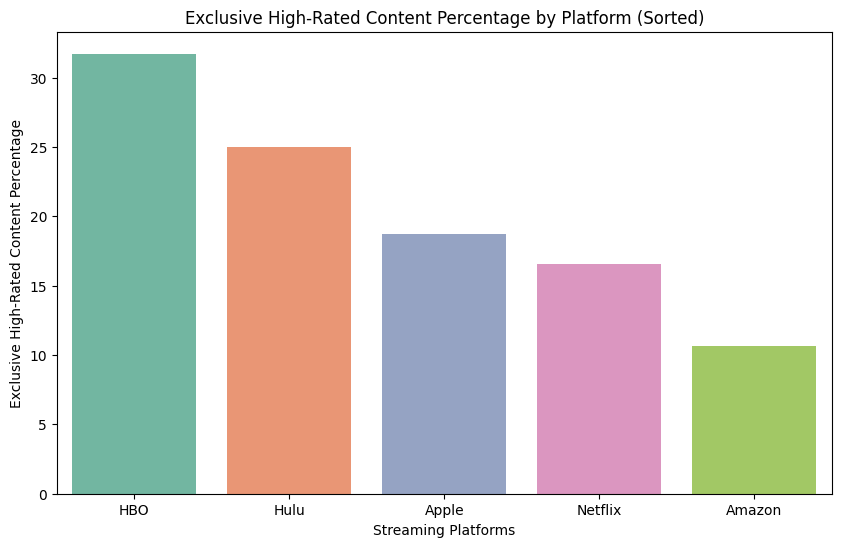

In [20]:
data = pd.DataFrame({
    'Platform': platforms,
    'Exclusive High-Rated Content (%)': exclusive_high_rated_percentages
})

# Sort the data in descending order based on the percentage of exclusive high-rated content
data = data.sort_values(by='Exclusive High-Rated Content (%)', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Platform', y='Exclusive High-Rated Content (%)', data=data, palette='Set2', hue='Platform')

# Adding labels and title
plt.xlabel('Streaming Platforms')
plt.ylabel('Exclusive High-Rated Content Percentage')
plt.title('Exclusive High-Rated Content Percentage by Platform (Sorted)')

# Save the plot
plt.savefig("C:\\Users\\kimbe\\Documents\\Capstone\\Streaming_Analysis\\outputs\\exclusive_high_rated_content_percentage_by_platform.png")

# Display the plot
plt.show()


# Analyze the Availability of Popular Content Across Platforms using a Kruskal-Wallis H-test

**Plan:**
We will test if there are significant differences in the percentage of popular titles from each platform's catalog, compared to the IMDb list of popular titles, across different streaming platforms.


1. Null Hypothesis (H₀): There are no significant differences in the percentage of popular content (platform's popular titles relative to IMDb's popular content list) available across the platforms.
2. Alternative Hypothesis (H₁): There is a significant difference in the percentage of popular content (platform's popular titles relative to IMDb's popular content list) available across the platforms.


**Dependent Variable:** The percentage of popular content available on each platform, relative to the IMDb list of popular titles.

The percentage for each platform is calculated as:
    
**Percentage of Popular Content = (Number of Popular Titles on Platform / Total Titles in IMDb Popular List) * 100**


These percentages represent the proportion of titles categorized as "popular" in each platform's catalog, compared to the total number of popular titles in the IMDb list.

## Statistical Test:
To evaluate whether the observed differences in popularity percentages are statistically significant, we will use a **Kruskal-Wallis H-test** since we have categorical groups (platforms) with a single observed value (percentage) for each group.

---

**Results**

| Platform | Titles Found | Percentage (%) |
|----------|--------------|----------------|
| HBO      | 94           | 17.97%         |
| Netflix  | 87           | 16.63%         |
| Apple    | 73           | 13.96%         |
| Hulu     | 73           | 13.96%         |
| Amazon   | 71           | 13.58%         |

* H-statistic: 4.00
* P-value: 0.4060

---

**Summary**

* The H-statistic (4.00) indicates the degree of difference between the groups, but we focus more on the p-value for making a decision.
* The p-value is 0.4060, which is greater than 0.05. **This means we fail to reject the null hypothesis.**


---

# Platform Overlap (All Popular Titles):


|             | Amazon | Hulu  | Netflix | Apple  | HBO    |
|-------------|--------|-------|---------|--------|--------|
| **Amazon**  |        | 7.46  | 2.60    | 12.50  | 4.43   |
| **Hulu**    | 7.46   |       | 8.84    | 7.35   | 1.83   |
| **Netflix** | **2.60**  | 8.84  |         | 3.90   | **1.69**   |
| **Apple**   | 12.50  | 7.35  | 3.90    |        | 1.83   |
| **HBO**     | 4.43   | **1.83** | **1.69**    | **1.83**   |        |



The following combinations will give you the most unique popular content:

* **HBO and Netflix**:

    * Overlap Percentage: 1.69%
    * This combination also provides very few shared titles, offering a good amount of unique content.

* **HBO and Hulu**:

    * Overlap Percentage: 1.83%
    * This combination has the lowest overlap, providing a very high number of unique titles.

* **Apple and HBO**:

    * Overlap Percentage: 1.83%
    * Like the HBO + Hulu combination, this one also provides a minimal overlap, maximizing the number of unique titles.



In [13]:
platform_percentages = {}

# Loop over each platform and calculate the percentage
for platform_name in platforms:
    # Filter the long_platform_catalog for the current platform
    platform_df = long_platform_catalog[long_platform_catalog['Platform'] == platform_name]
    
    # Merge 'popular_titles' with the platform's catalog on 'imdbId'
    merged_df = popular_titles.merge(platform_df[['imdbId', 'popularTitle']], left_on='id', right_on='imdbId', how='left')
    
    # Count how many titles in 'popular_titles' are present in the platform catalog
    found_count = merged_df[merged_df['popularTitle'] == 1].shape[0]
    
    # Calculate the percentage of found titles
    total_count = popular_titles.shape[0]
    percentage_found = (found_count / total_count) * 100
    
    # Store the percentage for each platform
    platform_percentages[platform_name] = percentage_found

    # Print the count and percentage for each platform
    print(f"{platform_name}: {found_count} titles found, {percentage_found:.2f}%")


Amazon: 71 titles found, 13.58%
Apple: 73 titles found, 13.96%
HBO: 94 titles found, 17.97%
Hulu: 73 titles found, 13.96%
Netflix: 87 titles found, 16.63%


Create a binary matrix of popular titles

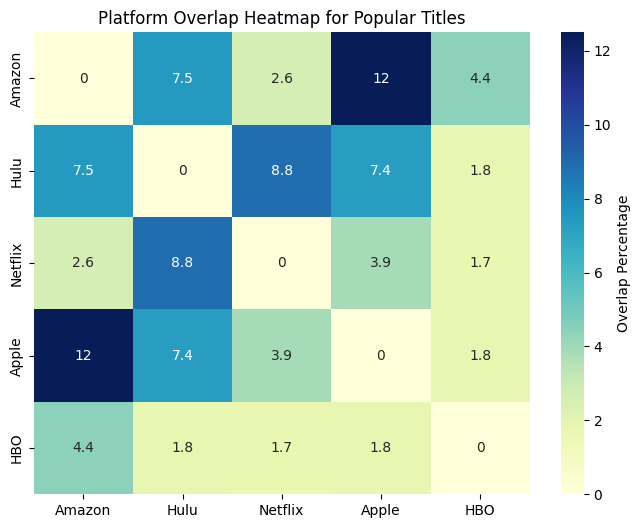

In [14]:
# Define platform columns and initialize an empty binary matrix
platform_columns = ['Amazon', 'Hulu', 'Netflix', 'Apple', 'HBO']
binary_overlap_matrix = pd.DataFrame(0.0, index=platform_columns, columns=platform_columns)  # Ensure it's a float matrix

# Loop through each pair of platforms to calculate overlap for popular titles
for platform_1 in platform_columns:
    for platform_2 in platform_columns:
        if platform_1 != platform_2:
            # Get the sets of popular titles for each platform
            set_1 = set(long_platform_catalog[
                (long_platform_catalog['Platform'] == platform_1) & 
                (long_platform_catalog['popularTitle'] == 1)
            ]['imdbId'])
            
            set_2 = set(long_platform_catalog[
                (long_platform_catalog['Platform'] == platform_2) & 
                (long_platform_catalog['popularTitle'] == 1)
            ]['imdbId'])
            
            # Calculate the overlap: number of common non-exclusive popular titles
            common_titles = set_1.intersection(set_2)
            total_titles = set_1.union(set_2)
            
            # Calculate the overlap percentage and update the binary overlap matrix
            if total_titles:  # Avoid division by zero if there are no titles
                overlap_percentage = len(common_titles) / len(total_titles) * 100
                # Set overlap for both directions (symmetry)
                binary_overlap_matrix.loc[platform_1, platform_2] = overlap_percentage
                binary_overlap_matrix.loc[platform_2, platform_1] = overlap_percentage  # Ensure symmetry

# Plot the heatmap of platform overlap for non-exclusive popular titles
plt.figure(figsize=(8, 6))
sns.heatmap(binary_overlap_matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Overlap Percentage'})
plt.title("Platform Overlap Heatmap for Popular Titles")

# Save the heatmap
plt.savefig("C:\\Users\\kimbe\\Documents\\Capstone\\Streaming_Analysis\\outputs\\platform_overlap_heatmap.png")

# Display the heatmap
plt.show()


In [15]:
binary_overlap_matrix


,Amazon,Hulu,Netflix,Apple,HBO
Amazon,0.000000,7.462687,2.597403,12.500000,4.430380
Hulu,7.462687,0.000000,8.843537,7.352941,1.829268
Netflix,2.597403,8.843537,0.000000,3.896104,1.685393
Apple,12.500000,7.352941,3.896104,0.000000,1.829268
HBO,4.430380,1.829268,1.685393,1.829268,0.000000


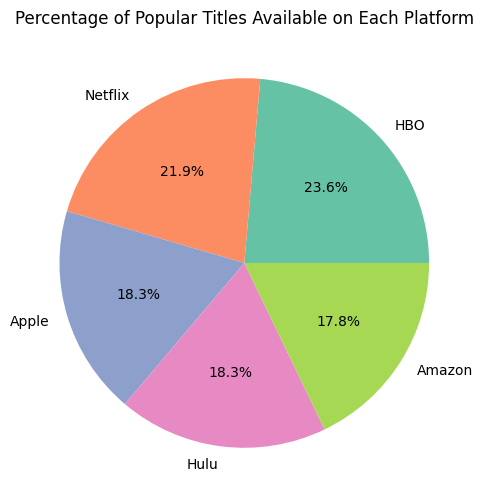

In [16]:
# Sort the platform_percentages dictionary by values in descending order
sorted_platform_percentages = dict(sorted(platform_percentages.items(), key=lambda item: item[1], reverse=True))

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(list(sorted_platform_percentages.values()), labels=list(sorted_platform_percentages.keys()), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(sorted_platform_percentages)))

# Add title
plt.title('Percentage of Popular Titles Available on Each Platform')

# Save the plot
plt.savefig("C:\\Users\\kimbe\\Documents\\Capstone\\Streaming_Analysis\\outputs\\percentage_of_popular_titles_by_platform.png")

# Display the plot
plt.show()


In [17]:
# Convert the dictionary values into a list (each platform as a separate group)
data_groups = list(platform_percentages.values())

# Perform Kruskal-Wallis H-test
H_statistic, p_value = stats.kruskal(*data_groups)

# Print the results
print(f"H-statistic: {H_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in the percentages of popular content across platforms.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the percentages of popular content across platforms.")


H-statistic: 4.00
P-value: 0.4060
Fail to reject the null hypothesis: There is no significant difference in the percentages of popular content across platforms.


# Analyze high-rated content for genres

We evaluated multiple streaming platforms (Amazon, Netflix, HBO, Hulu, and Apple) based on the percentage of high-rated content available in each genre. This approach helps identify which platforms offer the highest quality content per genre, highlighting platforms that curate more highly-rated titles in their catalogs.

**Findings**:
* **HBO** consistently leads in high-rated content percentages across the majority of genres, especially in *Drama*, *Comedy*, *Action*, *History*, *Sport*, and *Music*.
* **Apple** performs best in *Documentary*, *News*, and *Musical*.
* **Amazon** generally has the lowest percentages across most genres, except for *Reality-TV*, where it leads.
* **Hulu** stands out in *Talk-Show* and *War*, taking the top spot in those genres.


**Conclusion**:
* Based on the percentage of high-rated content, HBO is the top platform overall. However, this analysis is focused solely on quality. If broader content variety or catalog size is more important, other platforms may be worth considering.

Discover the platform that excels in providing high-rated content across various genres. High-rated content is defined as movies and TV shows with an IMDb rating of 7.5 or higher.

In [18]:
# Define the genre columns
genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 
                 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                 'Reality-TV', 'Romance', 'Science Fiction', 'Short', 'Sport', 
                 'TV Movie', 'Talk-Show', 'Thriller', 'War', 'Western']

# Define function to calculate high-rated content by genre
def high_rated_by_genre(df, genre_columns):
    """
    Calculate the percentage of high-rated content (IMDb >= 7.5) by genre.

    Parameters:
    df (DataFrame): The DataFrame containing the content data.
    genre_columns (list): List of genre columns.

    Returns:
    Series: A Series containing the percentage of high-rated content per genre.
    """
    # Filter for high-rated content (IMDb >= 7.5)
    high_rated_df = df[df['rating'] >= 7.5]
    
    # Count the number of high-rated content per genre (one-hot encoded)
    genre_counts = high_rated_df[genre_columns].sum()
    
    # Calculate total number of content per genre across all rows
    total_counts = df[genre_columns].sum()
    
    # Calculate percentage of high-rated content per genre
    percentage = (genre_counts / total_counts) * 100
    return percentage

# Assuming platforms is a list of platform names (e.g., ['Amazon', 'Netflix', 'HBO', 'Hulu', 'Apple'])
platforms = ['Amazon', 'Netflix', 'HBO', 'Hulu', 'Apple']  # Modify as per your actual platforms

# Assuming platform_info is your DataFrame
high_rated_genre_percentage = {}

# Loop through platforms and calculate high-rated content percentage by genre
for platform in platforms:
    # Filter the DataFrame for each platform (assuming platform columns are binary: 0 or 1)
    platform_df = platform_catalog[platform_catalog[platform] == 1]  # Filter rows where the platform column is 1
    high_rated_genre_percentage[platform] = high_rated_by_genre(platform_df, genre_columns)

# Convert results to DataFrame for easier visualization
high_rated_genre_percentage_df = pd.DataFrame(high_rated_genre_percentage)

# Display the resulting DataFrame
print(high_rated_genre_percentage_df)




                    Amazon    Netflix        HBO       Hulu      Apple
Action            5.621851  19.227540  28.762542  28.351648  11.171032
Adventure         8.490133  22.382671  31.097561  33.608815  15.438108
Animation        17.733990  26.758794  38.265306  38.219895  21.594684
Biography        23.032407  27.793696  37.073171  32.142857  29.342723
Comedy            9.058989  16.983471  28.904847  26.583851  12.513034
Crime             8.946034  18.363636  31.024931  29.722922  19.463549
Documentary      35.964259  28.169014  34.392265  35.024155  45.273264
Drama             9.461745  21.846554  39.482565  29.529530  15.678134
Family           11.002786  13.202247  38.053097  14.666667  11.311673
Fantasy           8.149569  21.568627  25.190840  22.068966   9.158416
Film-Noir         6.382979        NaN  60.000000        NaN   8.333333
Game-Show        19.672131  20.000000  20.588235  12.068966  45.238095
History          28.088427  31.914894  44.354839  36.190476  43.923241
Horror

# Top 3 Platforms by Genre

| **Genre**        | **1st**           | **2nd**           | **3rd**           |
|-------------------|-------------------|-------------------|-------------------|
| Action           | HBO (28.8%)      | Hulu (28.4%)      | Netflix (19.2%)   |
| Adventure        | Hulu (33.6%)     | HBO (31.1%)       | Netflix (22.4%)   |
| Animation        | Hulu (38.2%)     | HBO (38.3%)       | Netflix (26.8%)   |
| Biography        | HBO (37.1%)      | Hulu (32.1%)      | Apple (29.3%)     |
| Comedy           | HBO (28.9%)      | Hulu (26.6%)      | Netflix (17.0%)   |
| Crime            | HBO (31.0%)      | Hulu (29.7%)      | Apple (19.5%)     |
| Documentary      | Apple (45.3%)    | Amazon (36.0%)    | Hulu (35.0%)      |
| Drama            | HBO (39.5%)      | Hulu (29.5%)      | Netflix (21.8%)   |
| Family           | HBO (38.1%)      | Hulu (14.7%)      | Apple (11.3%)     |
| Fantasy          | HBO (25.2%)      | Hulu (22.1%)      | Netflix (21.6%)   |
| Film-Noir        | HBO (60.0%)      | Amazon (6.4%)     | Apple (8.3%)      |
| Game-Show        | Apple (45.2%)    | Netflix (20.0%)   | HBO (20.6%)       |
| History          | HBO (44.4%)      | Apple (43.9%)     | Hulu (36.2%)      |
| Horror           | HBO (10.1%)      | Hulu (7.5%)       | Netflix (8.0%)    |
| Music            | HBO (43.2%)      | Apple (22.9%)     | Hulu (26.7%)      |
| Musical          | HBO (47.1%)      | Apple (20.2%)     | Netflix (19.4%)   |
| Mystery          | HBO (28.2%)      | Hulu (24.0%)      | Netflix (15.8%)   |
| News             | Apple (50.0%)    | Amazon (43.8%)    | Netflix (33.3%)   |
| Reality-TV       | Apple (31.0%)    | Amazon (31.9%)    | HBO (29.3%)       |
| Romance          | HBO (33.0%)      | Hulu (21.8%)      | Netflix (18.0%)   |
| Science Fiction  | HBO (22.0%)      | Hulu (13.8%)      | Apple (11.3%)     |
| Short            | HBO (26.8%)      | Apple (25.0%)     | Amazon (25.4%)    |
| Sport            | HBO (42.2%)      | Apple (31.6%)     | Hulu (31.6%)      |
| TV Movie         | Amazon (33.3%)   | Apple (14.3%)     | N/A               |
| Talk-Show        | Hulu (54.5%)     | Apple (26.9%)     | Netflix (24.1%)   |
| Thriller         | HBO (25.0%)      | Hulu (10.3%)      | Netflix (9.8%)    |
| War              | HBO (51.0%)      | Hulu (53.3%)      | Apple (33.3%)     |
| Western          | Hulu (22.2%)     | Netflix (20.0%)   | HBO (17.6%)       |

# Top 3 Genres by Platform

| **Platform**     | **1st Genre**     | **2nd Genre**     | **3rd Genre**     |
|-------------------|-------------------|-------------------|-------------------|
| Amazon           | News (43.8%)      | Documentary (36.0%) | Reality-TV (31.9%) |
| Netflix          | Adventure (22.4%) | Animation (26.8%)   | Biography (27.8%)  |
| HBO              | Film-Noir (60.0%) | War (51.0%)         | History (44.4%)    |
| Hulu             | Talk-Show (54.5%) | War (53.3%)         | Animation (38.2%)  |
| Apple            | News (50.0%)      | Game-Show (45.2%)   | Documentary (45.3%) |
